# Hierarchical Model with non-common $\sigma^2$ and fixed $\nu$

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import poisson, norm, invgamma

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
J = 6

np.random.seed(111)
N = poisson.rvs(3, size=J, loc=10)

MU  = -9
TAU = 1
RHO = 3
NU  = 4

np.random.seed(111)
THETA  = norm.rvs(size=J, loc=MU, scale=TAU)
SIGMA2 = invgamma.rvs(size=J, a=NU/2, scale=NU/2*RHO**2)

SIGMA = np.sqrt(SIGMA2)

ALPHA_LEVEL = 0.05

VARIABLE = 'Y'

Create the data

In [3]:
Y = norm.rvs(size=N[0], loc=THETA[0], scale=SIGMA[0])
Dat = pd.DataFrame(np.array([Y, [0]*N[0]]).T)

for j in range(1,J):
    Y = norm.rvs(size=N[j], loc=THETA[j], scale=SIGMA[j])
    DatAux = pd.DataFrame(np.array([Y, [j]*N[j]]).T)
    Dat = pd.concat([Dat, DatAux])

Dat = Dat.rename(columns={0:VARIABLE, 1:'Region'})
Dat['Region'] = Dat['Region'].astype(int)

Calculate the statistics per region

In [4]:
DatRegion = Dat[[VARIABLE, 'Region']].groupby('Region').agg(['count', 'mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '':'Region'
        , 'count': 'NumberObservations'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'}
    )

DatRegion['Theta'] = THETA
DatRegion['Sigma'] = SIGMA

In [5]:
Dat = pd.merge(
    Dat
    , DatRegion[['Region', VARIABLE + 'Mean', VARIABLE + 'Std']]
)

---

In [6]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

HatNu = 2 * ES2**2 / VS2 + 4
HatRho2 = (ES2**2 + VS2) / (ES2**2 + 2*VS2) * ES2

In [17]:
round(HatNu,2), round(np.sqrt(HatRho2),2)

(4.81, 3.34)

In [8]:
def ESigma2Func(j, nu):
    DatAux = DatRegion[DatRegion['Region']== j]
    return (nu * HatRho2 + DatAux['NumberObservations'] * DatAux[VARIABLE + 'Std']**2) / (nu + DatAux['NumberObservations'] - 2)

ESigma2Func = np.vectorize(ESigma2Func)

def StdSigma2Func(j, nu):
    DatAux = DatRegion[DatRegion['Region']== j]
    return np.sqrt(2) * (nu * HatRho2 + DatAux['NumberObservations'] * DatAux[VARIABLE + 'Std']**2) / ((nu + DatAux['NumberObservations'] - 2) * np.sqrt(nu + DatAux['NumberObservations'] - 4))

StdSigma2Func = np.vectorize(StdSigma2Func)

In [9]:
NuVect = np.linspace(0.01,40,100)

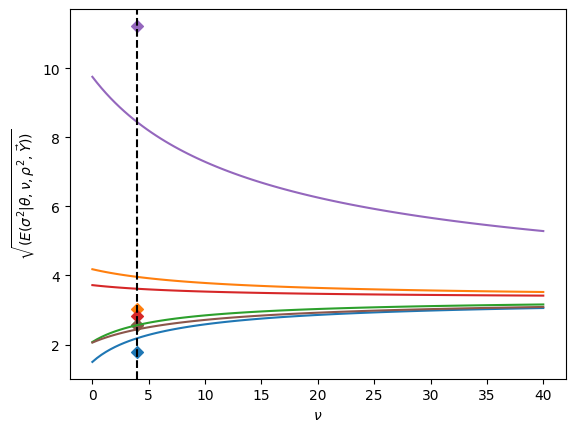

In [13]:
for j in DatRegion['Region']:
    plt.plot(NuVect, np.sqrt(ESigma2Func(j, NuVect)))
    plt.scatter(NU, SIGMA[j], marker='D')

plt.xlabel(r'$\nu$')
plt.ylabel(r'$\sqrt{(E(\sigma^2|\theta,\nu,\rho^2,\vec{Y}))}$')
plt.axvline(NU, ls='--', color='k')

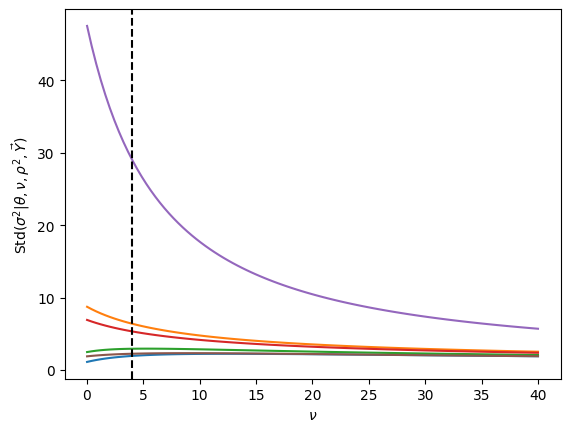

In [15]:
for j in DatRegion['Region']:
    plt.plot(NuVect, StdSigma2Func(j, NuVect))

plt.xlabel(r'$\nu$')
plt.ylabel(r'Std$(\sigma^2|\theta,\nu,\rho^2,\vec{Y})$')
plt.axvline(NU, ls='--', color='k')